# LightGBM

* LightGBM.ipynb에서는 train--.csv 와 test--.csv 의 데이터를 그대로 train data와 test 데이터로 사용했었다.
* 그 데이터에 불균형이 많이 발견되었으며, 데이터의 정규화도 이루어지지 않았다.
* 이번에 train, test 데이터를 균등하게 나누어 보고, MinMaxScaler를 사용하여 정규화를 하고, SMOTE를 사용하여 오버샘플링을 해 보았다.
* 결과, 기존에 train accuracy가 0.59, test accuracy가 0.78 였던 것에 비해 train accuracy는 0.95, test accuracy는 0.91 으로 나타났다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path="/content/drive/MyDrive/빅데이터 팀플/dementia_analytics/"

# Train-Test 를 라벨 별로 균등하게 나누기 전

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 로딩 ### 
train_dataset = pd.read_csv(path + 'data_processing/dataset_03/training/train_dataset_with_label_fill_user_mean.csv')
valid_dataset = pd.read_csv(path + 'data_processing/dataset_03/validation/val_dataset_with_label_fill_user_mean.csv')

train_output = train_dataset[['DIAG_NM']]
train_input = train_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

test_output = valid_dataset[['DIAG_NM']]
test_input = valid_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(train_input)
train_input = scaler.fit_transform(train_input)
test_input = scaler.fit_transform(test_input)

In [15]:
### 레이블 인코딩 ### 

# 트리 기반 알고리즘에서는 숫자의 크기에 따른 중요도 차이가 없어 레이블 인코딩 OK
# 선형적 특징을 가지는 알고리즘들은 one hot encoding 통해 해결해야 함

from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
# CN : 0, Dem : 1, MCI : 2
items = ['CN', 'Dem', 'MCI']
encoder = LabelEncoder()
encoder.fit(items)

# train
train_output['DIAG_NM'] = encoder.transform(train_output['DIAG_NM'])
# display(encoder.classes_)
# display(encoder.inverse_transform(train_output['DIAG_NM']))

# test
test_output['DIAG_NM'] = encoder.transform(test_output['DIAG_NM'])

<ipython-input-15-e819ad067ec6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_output['DIAG_NM'] = encoder.transform(train_output['DIAG_NM'])
<ipython-input-15-e819ad067ec6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_output['DIAG_NM'] = encoder.transform(test_output['DIAG_NM'])


In [16]:
### Light GBM ###
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()
evals = [(test_input, test_output)]
LGBM.fit(train_input, train_output, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
test_pred = LGBM.predict(test_input)
train_pred = LGBM.predict(train_input)
# pred_proba = LGBM.predict_proba(test_input)[:1]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a

[1]	valid_0's multi_logloss: 0.791948
[2]	valid_0's multi_logloss: 0.789925
[3]	valid_0's multi_logloss: 0.790271
[4]	valid_0's multi_logloss: 0.792056
[5]	valid_0's multi_logloss: 0.794073
[6]	valid_0's multi_logloss: 0.793791
[7]	valid_0's multi_logloss: 0.79282
[8]	valid_0's multi_logloss: 0.795642
[9]	valid_0's multi_logloss: 0.797257
[10]	valid_0's multi_logloss: 0.802295
[11]	valid_0's multi_logloss: 0.80637
[12]	valid_0's multi_logloss: 0.806304
[13]	valid_0's multi_logloss: 0.805972
[14]	valid_0's multi_logloss: 0.804303
[15]	valid_0's multi_logloss: 0.804909
[16]	valid_0's multi_logloss: 0.805186
[17]	valid_0's multi_logloss: 0.806756
[18]	valid_0's multi_logloss: 0.811269
[19]	valid_0's multi_logloss: 0.809089
[20]	valid_0's multi_logloss: 0.809348
[21]	valid_0's multi_logloss: 0.812149
[22]	valid_0's multi_logloss: 0.815502
[23]	valid_0's multi_logloss: 0.816253
[24]	valid_0's multi_logloss: 0.814126
[25]	valid_0's multi_logloss: 0.814888
[26]	valid_0's multi_logloss: 0.8186

In [17]:
# 균등하게 나누기 전
from sklearn.metrics import accuracy_score

print(accuracy_score(train_output, train_pred))
print(accuracy_score(test_output, test_pred))

0.5996824276640791
0.7840054682159945


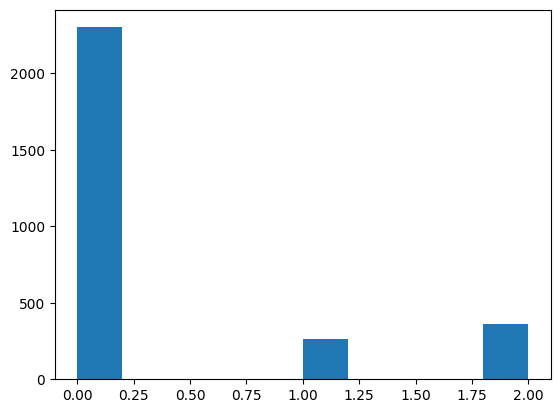

In [18]:
import matplotlib.pyplot as plt

plt.hist(test_output)
plt.show()

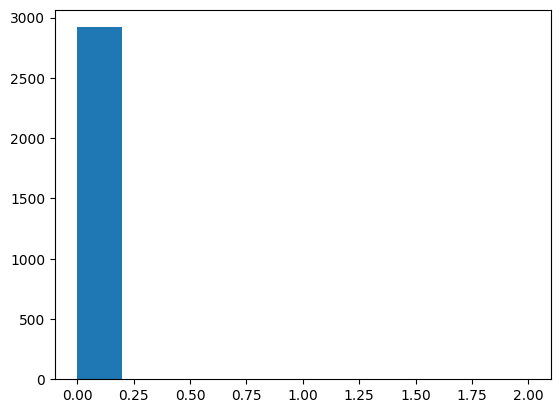

In [19]:
plt.hist(test_pred)
plt.show()

이를 통해, Train-Test를 균등하게 나누기 전에는 모델이 모든 데이터에 대해 하나의 라벨로만 분류하였다는 것을 알 수 있다.

# Train-Test 을 각 라벨 별로 균등하게 나눈 후

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 로딩 ### 
train_dataset = pd.read_csv(path + 'data_processing/dataset_03/training/train_dataset_with_label_fill_user_mean.csv')
valid_dataset = pd.read_csv(path + 'data_processing/dataset_03/validation/val_dataset_with_label_fill_user_mean.csv')

train_output = train_dataset[['DIAG_NM']]
train_input = train_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

test_output = valid_dataset[['DIAG_NM']]
test_input = valid_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

In [21]:
data_input = pd.concat([train_input, test_input], ignore_index=True)
data_output = pd.concat([train_output, test_output], ignore_index=True)

## 오버샘플링 전


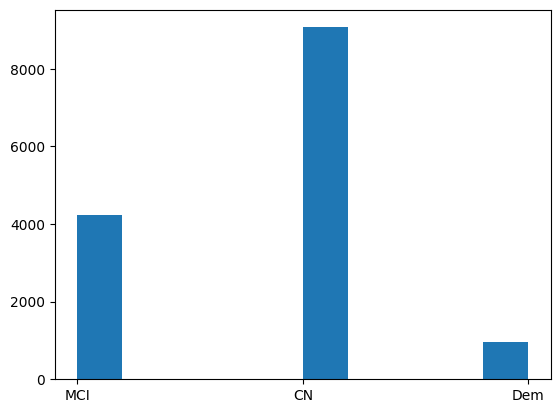

In [22]:
# 오버샘플링 전
import matplotlib.pyplot as plt

plt.hist(data_output)
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(train_input)
data_input = scaler.fit_transform(data_input)
print(data_input)

[[0.5952381  0.26400374 0.27586207 ... 0.23344948 0.36159776 0.01592357]
 [0.5952381  0.25136527 0.24137931 ... 0.15214866 0.32305536 0.02229299]
 [0.54761905 0.23669839 0.22413793 ... 0.14518002 0.41906097 0.01512739]
 ...
 [0.54761905 0.35481354 0.34482759 ... 0.33587744 0.42813094 0.2024492 ]
 [0.57142857 0.33655797 0.31034483 ... 0.33587744 0.42813094 0.2024492 ]
 [0.63095238 0.45997816 0.44827586 ... 0.33587744 0.42813094 0.2024492 ]]


In [24]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_output, test_output = train_test_split(data_input, data_output, test_size=0.2, shuffle=True, stratify=data_output, random_state=42)

In [25]:
### 레이블 인코딩 ### 

# 트리 기반 알고리즘에서는 숫자의 크기에 따른 중요도 차이가 없어 레이블 인코딩 OK
# 선형적 특징을 가지는 알고리즘들은 one hot encoding 통해 해결해야 함

from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
# CN : 0, Dem : 1, MCI : 2
items = ['CN', 'Dem', 'MCI']
encoder = LabelEncoder()
encoder.fit(items)

# train
train_output['DIAG_NM'] = encoder.transform(train_output['DIAG_NM'])
# display(encoder.classes_)
# display(encoder.inverse_transform(train_output['DIAG_NM']))

# test
test_output['DIAG_NM'] = encoder.transform(test_output['DIAG_NM'])

In [26]:
### Light GBM ###
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()
evals = [(test_input, test_output)]
LGBM.fit(train_input, train_output, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
test_pred = LGBM.predict(test_input)
train_pred = LGBM.predict(train_input)
# pred_proba = LGBM.predict_proba(test_input)[:1]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a

[1]	valid_0's multi_logloss: 0.777448
[2]	valid_0's multi_logloss: 0.744842
[3]	valid_0's multi_logloss: 0.720335
[4]	valid_0's multi_logloss: 0.699928
[5]	valid_0's multi_logloss: 0.680991
[6]	valid_0's multi_logloss: 0.664904
[7]	valid_0's multi_logloss: 0.65012
[8]	valid_0's multi_logloss: 0.636651
[9]	valid_0's multi_logloss: 0.623992
[10]	valid_0's multi_logloss: 0.612805
[11]	valid_0's multi_logloss: 0.603539
[12]	valid_0's multi_logloss: 0.593902
[13]	valid_0's multi_logloss: 0.585515
[14]	valid_0's multi_logloss: 0.578552
[15]	valid_0's multi_logloss: 0.570998
[16]	valid_0's multi_logloss: 0.563634
[17]	valid_0's multi_logloss: 0.557328
[18]	valid_0's multi_logloss: 0.551625
[19]	valid_0's multi_logloss: 0.54519
[20]	valid_0's multi_logloss: 0.539429
[21]	valid_0's multi_logloss: 0.53389
[22]	valid_0's multi_logloss: 0.529295
[23]	valid_0's multi_logloss: 0.524027
[24]	valid_0's multi_logloss: 0.520381
[25]	valid_0's multi_logloss: 0.516557
[26]	valid_0's multi_logloss: 0.51317

In [27]:
# 오버샘플링 전
from sklearn.metrics import accuracy_score

print(accuracy_score(train_output, train_pred))
print(accuracy_score(test_output, test_pred))

0.9368919274257166
0.8307045215562566


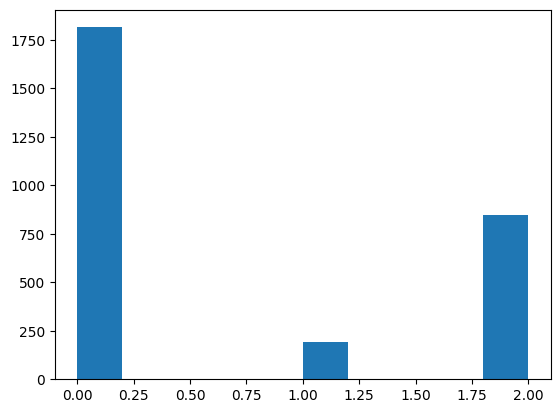

In [28]:
plt.hist(test_output)
plt.show()

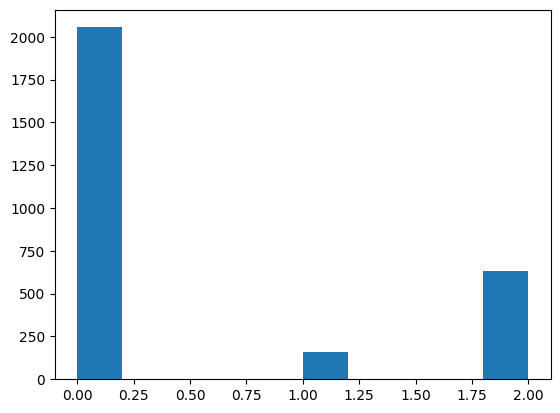

In [29]:
plt.hist(test_pred)
plt.show()

데이터를 균등하게 나눈 후에는 모든 데이터를 같은 라벨로 분류하지는 않지만 데이터 자체의 불균형 때문에 과적합 되어 있음을 볼 수 있다.

## 오버샘플링 후

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 로딩 ### 
train_dataset = pd.read_csv(path + 'data_processing/dataset_03/training/train_dataset_with_label_fill_user_mean.csv')
valid_dataset = pd.read_csv(path + 'data_processing/dataset_03/validation/val_dataset_with_label_fill_user_mean.csv')

train_output = train_dataset[['DIAG_NM']]
train_input = train_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

test_output = valid_dataset[['DIAG_NM']]
test_input = valid_dataset[['sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_restless', 'sleep_midpoint_at_delta', 'activity_cal_total', 'activity_met_min_inactive', 'activity_met_min_high', 'activity_score_meet_daily_targets', 'sleep_rem', 'sleep_light', 'activity_low', 'activity_rest', 'activity_met_min_medium']]

In [31]:
data_input = pd.concat([train_input, test_input], ignore_index=True)
data_output = pd.concat([train_output, test_output], ignore_index=True)

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(train_input)
data_input = scaler.fit_transform(data_input)
print(data_input)

[[0.5952381  0.26400374 0.27586207 ... 0.23344948 0.36159776 0.01592357]
 [0.5952381  0.25136527 0.24137931 ... 0.15214866 0.32305536 0.02229299]
 [0.54761905 0.23669839 0.22413793 ... 0.14518002 0.41906097 0.01512739]
 ...
 [0.54761905 0.35481354 0.34482759 ... 0.33587744 0.42813094 0.2024492 ]
 [0.57142857 0.33655797 0.31034483 ... 0.33587744 0.42813094 0.2024492 ]
 [0.63095238 0.45997816 0.44827586 ... 0.33587744 0.42813094 0.2024492 ]]


In [33]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

data_input, data_output = sm.fit_resample(data_input, data_output)

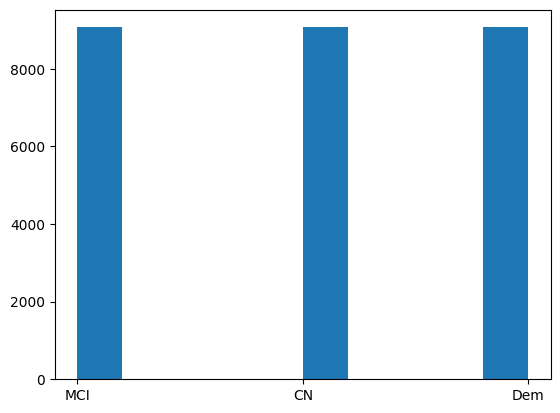

In [34]:
# 오버샘플링 후
import matplotlib.pyplot as plt

plt.hist(data_output)
plt.show()

In [35]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_output, test_output = train_test_split(data_input, data_output, test_size=0.2, shuffle=True, stratify=data_output, random_state=42)

In [36]:
### 레이블 인코딩 ### 

# 트리 기반 알고리즘에서는 숫자의 크기에 따른 중요도 차이가 없어 레이블 인코딩 OK
# 선형적 특징을 가지는 알고리즘들은 one hot encoding 통해 해결해야 함

from sklearn.preprocessing import LabelEncoder

# 라벨인코더 선언 및 Fitting
# CN : 0, Dem : 1, MCI : 2
items = ['CN', 'Dem', 'MCI']
encoder = LabelEncoder()
encoder.fit(items)

# train
train_output['DIAG_NM'] = encoder.transform(train_output['DIAG_NM'])
# display(encoder.classes_)
# display(encoder.inverse_transform(train_output['DIAG_NM']))

# test
test_output['DIAG_NM'] = encoder.transform(test_output['DIAG_NM'])

In [37]:
### Light GBM ###
from lightgbm import LGBMClassifier

LGBM = LGBMClassifier()
evals = [(test_input, test_output)]
LGBM.fit(train_input, train_output, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
test_pred = LGBM.predict(test_input)
train_pred = LGBM.predict(train_input)
# pred_proba = LGBM.predict_proba(test_input)[:1]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a

[1]	valid_0's multi_logloss: 1.02554
[2]	valid_0's multi_logloss: 0.964545
[3]	valid_0's multi_logloss: 0.911678
[4]	valid_0's multi_logloss: 0.867158
[5]	valid_0's multi_logloss: 0.826253
[6]	valid_0's multi_logloss: 0.790045
[7]	valid_0's multi_logloss: 0.757057
[8]	valid_0's multi_logloss: 0.728094
[9]	valid_0's multi_logloss: 0.70158
[10]	valid_0's multi_logloss: 0.677658
[11]	valid_0's multi_logloss: 0.655038
[12]	valid_0's multi_logloss: 0.634659
[13]	valid_0's multi_logloss: 0.616717
[14]	valid_0's multi_logloss: 0.599794
[15]	valid_0's multi_logloss: 0.583869
[16]	valid_0's multi_logloss: 0.56899
[17]	valid_0's multi_logloss: 0.554448
[18]	valid_0's multi_logloss: 0.541389
[19]	valid_0's multi_logloss: 0.529759
[20]	valid_0's multi_logloss: 0.5179
[21]	valid_0's multi_logloss: 0.507138
[22]	valid_0's multi_logloss: 0.497053
[23]	valid_0's multi_logloss: 0.487393
[24]	valid_0's multi_logloss: 0.478585
[25]	valid_0's multi_logloss: 0.469653
[26]	valid_0's multi_logloss: 0.461646


In [38]:
# 오버샘플링 후
from sklearn.metrics import accuracy_score

print(accuracy_score(train_output, train_pred))
print(accuracy_score(test_output, test_pred))

0.9546122748989342
0.9110621095185594


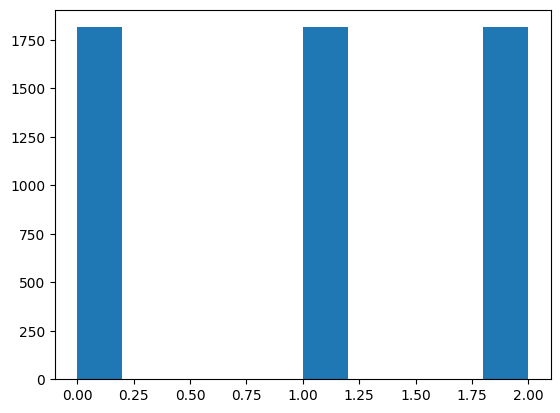

In [39]:
plt.hist(test_output)
plt.show()

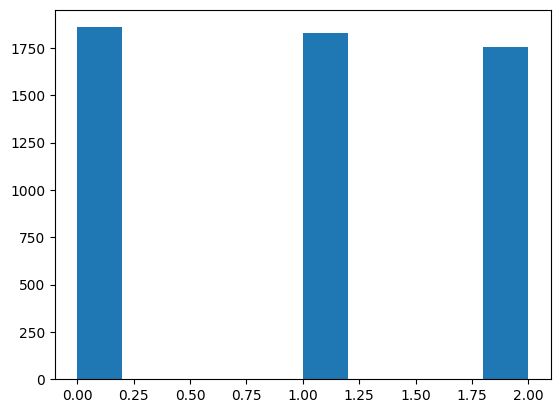

In [40]:
plt.hist(test_pred)
plt.show()

SMOTE를 사용하여 데이터 불균형 문제를 해결하니 모델이 비교적 과적합되지 않았으며, accuracy가 향상된 것을 볼 수 있다.

<function matplotlib.pyplot.show(close=None, block=None)>

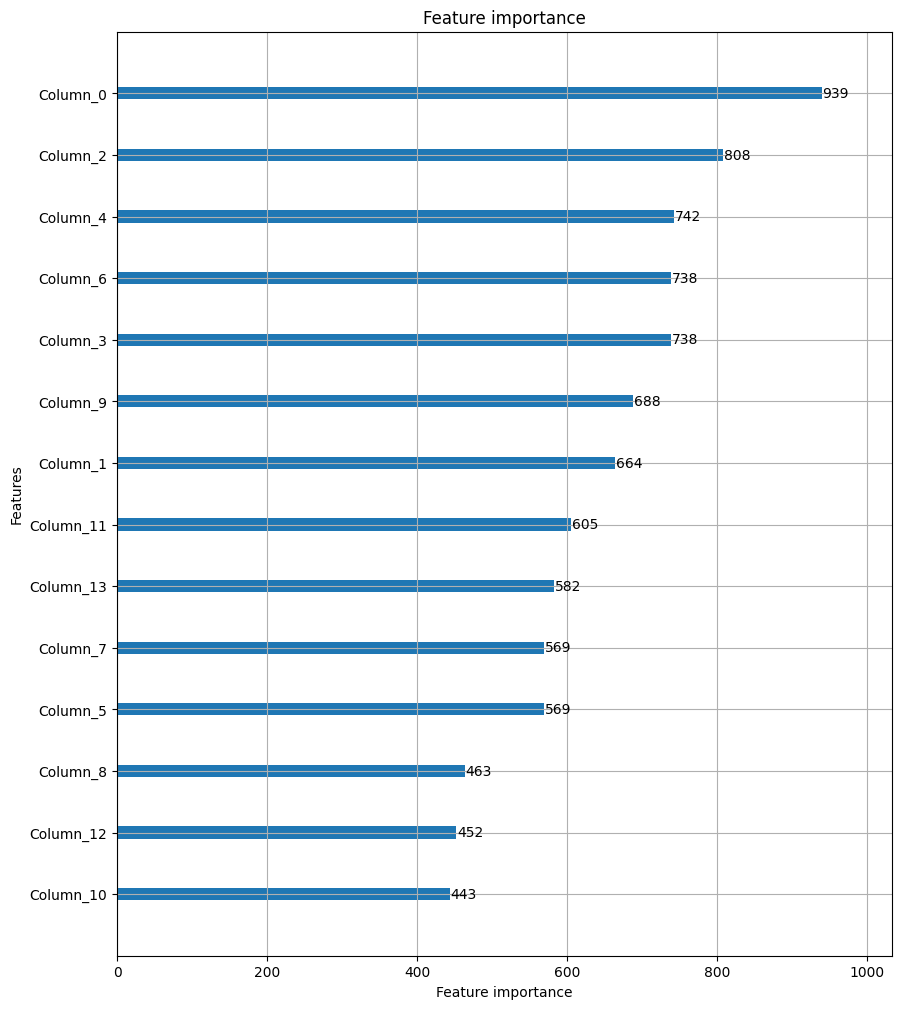

In [42]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(LGBM, ax=ax)
plt.show